In [3]:
import torch
import torchvision
import torch.nn as nn
import copy
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as transforms

import numpy as np

import timeit

In [4]:
gpu_dtype = torch.cuda.FloatTensor

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [6]:
fixed_model_base = nn.Sequential(
                nn.Conv2d(3,32,kernel_size=7,stride=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=2,stride=2),
                Flatten(),
                nn.Linear(5408,1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024,2)
            )

fixed_model = fixed_model_base.type(gpu_dtype)
fixed_model2 = copy.deepcopy(fixed_model_base).type(gpu_dtype)

In [7]:
fixed_model.load_state_dict(torch.load("left_right_model_gpu"))
fixed_model2.load_state_dict(torch.load("open_closed_model_gpu"))

In [8]:
transform = transforms.Compose(
    [transforms.Scale((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [9]:
testset = dset.ImageFolder(root='right_left_test',transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True,num_workers=2)

testset2 = dset.ImageFolder(root='open_closed_test',transform=transform)
testloader2 = torch.utils.data.DataLoader(testset2,batch_size=4,shuffle=True,num_workers=2)

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def display_class(labels):
    classes = []
    for label in labels:
        if label == 0:
            classes.append("left")
        elif label == 1:
            classes.append("right")
    return classes

def display_class2(labels):
    classes = []
    for label in labels:
        if label == 0:
            classes.append("closed")
        elif label == 1:
            classes.append("open")
    return classes

<class 'torch.Tensor'>


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


preds:  tensor([ 0,  1,  0,  0])
preds: ['left', 'right', 'left', 'left']
actual:  ['left', 'right', 'left', 'left']

preds2: tensor([ 1,  1,  1,  1])
preds2: ['open', 'open', 'open', 'open']

<class 'torch.Tensor'>


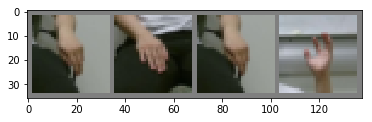

In [11]:
count = 0
for x, y in testloader:
        print(type(x))
        if count == 1:
            break
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = fixed_model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        imshow(torchvision.utils.make_grid(x))
        print("preds: " , preds)
        #print("x: ", x)
        print("preds:", display_class(preds))
        print("actual: ", display_class(y))
        
        
        print()
        scores2 = fixed_model2(x_var)
        _, preds2 = scores2.data.cpu().max(1)
        
        print("preds2:", preds2)
        print("preds2:", display_class2(preds2))
       
        print()
        
        #num_correct += (preds == y).sum()
        #num_samples += preds.size(0)
        count += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """



preds:  tensor([ 0,  1,  0,  0])
preds: ['left', 'right', 'left', 'left']

preds2: ['open', 'closed', 'open', 'open']
preds2: tensor([ 1,  0,  1,  1])
actual:  ['open', 'closed', 'open', 'open']


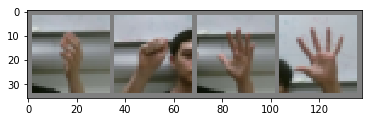

In [12]:
count = 0
for x, y in testloader2:
        if count == 1:
            break
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        
        scores = fixed_model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        scores2 = fixed_model2(x_var)
        _, preds2 = scores2.data.cpu().max(1)
        
        print()
        print("preds: " , preds)
        print("preds:", display_class(preds))
        print()
        
        print("preds2:", display_class2(preds2))
        print("preds2:", preds2)
        print("actual: ", display_class2(y))
        
        
        imshow(torchvision.utils.make_grid(x))
     
        #num_correct += (preds == y).sum()
        #num_samples += preds.size(0)
        count += 1